In [1]:
import sys
sys.path.insert(0, '..')

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from skimage.measure import label,regionprops
from matplotlib_scalebar.scalebar import ScaleBar
from skimage.transform import rescale
import dognet
from sklearn.metrics import roc_curve, auc

### Load data

In [2]:
def load_annotation(path,scale,synapses_indexes=None):
    anno = np.load(path)['collman15v2_annotation']
    layer = []
    for i in range(anno.shape[0]):
        pt = []
        props = regionprops(anno[i])
        for p in props:
            if (synapses_indexes is not None):
                if (p.label in synapses_indexes):
                    pt.append(np.array(p.centroid)*scale)
            else:
                pt.append(np.array(p.centroid)*scale)
        layer.append(pt)
    return layer
collman = np.load('../datasets/collman15/collman_large.npy')
b = load_annotation("../datasets/collman15/collman15v2_annotation.npz",0.05)

In [3]:
#make training data (0-7 layers are reserved for testing with probabilitic model)
from skimage.draw import circle
def make_labels(img,xs,ys,radius=5):
    labels = np.zeros(img.shape[1:])
    for xv,yv in zip(xs,ys):
        rr,cc = circle(xv,yv,radius,labels.shape)
        
        labels[rr,cc]=1
    return labels

#Train set
def make_training_set(labels,indexes):
    train_images = []
    train_labels = []
    for i in indexes:
        d = make_labels(collman[:,0],np.array(labels[i])[:,0],np.array(labels[i])[:,1])
        train_images.append(collman[:,i-2:i+2].mean(axis=1))
        train_labels.append(d)
    return train_images,train_labels
train_images,train_labels = make_training_set(b,range(2,3))

In [4]:
import torch

def inference(net,image,get_inter = False):
    x = np.expand_dims(image,0)
    vx = torch.from_numpy(x).float().cuda()
    res,inter = net(vx)
    if get_inter:
        return res.data.cpu().numpy(),inter.data.cpu().numpy()
    return res.data.cpu().numpy()

def estimate_quality(collman,net,layer,slices=[2,3,4,5,6],th=0.4):
    mprecision=[]
    mrecall=[]
    mf1_score=[]
    auc_score=[]
    for s in slices:
        y  = inference(net,collman[:,s-2:s+2].mean(axis=1))
        y_gt = make_labels(collman[:,0],np.array(layer[s])[:,0],np.array(layer[s])[:,1])
        fpr, tpr, thresholds = roc_curve( y_gt.flatten(),y[0,0].flatten())
        auc_score.append(auc(fpr, tpr))
            
        gt_pts = np.array([np.array(layer[s])[:,1],np.array(layer[s])[:,0]]).transpose(1,0)
        #print(gt_pts)
        coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>th)) if p.area>5])
        #print(coords)
        dog_pts = np.array([coords[:,1],coords[:,0]]).transpose(1,0)
        
        precision,recall,f1_score,_ = dognet.get_metric(gt_pts,dog_pts,s=10.)
        
        mprecision.append(precision)
        mrecall.append(recall)
        mf1_score.append(f1_score)
        
    return np.mean(mf1_score),np.mean(mprecision),np.mean(mrecall),np.mean(auc_score)

### Train DoGNet on collman

67
(tensor([ 122.1447], device='cuda:0'), (10, 1, 64, 64), 4096, 318.0, 1.0)
<function soft_dice_loss at 0x7fbc30cbf7d0>
Training started!
[====================] 100%
Training finished!
(0.7440883956336248, 0.7022435190618227, 0.8000715752982449, 0.8391158655055926)


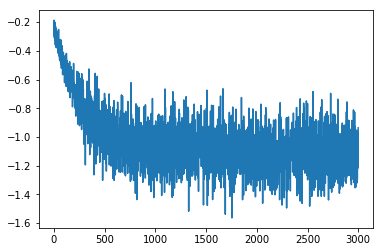

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = dognet.SimpleAnisotropic(3,15,3,2,learn_amplitude=False).to(device)
net.weights_init()
  
print(dognet.get_n_params(net))
net,errors =dognet.train_routine(net.cuda(),dognet.create_generator(train_images,train_labels),n_iter=3000,margin=5,loss='softdice',lr=0.001)
print(estimate_quality(collman,net,b,slices=range(4,25)))
plt.plot(np.log(errors))

In [8]:
nets =[dognet.SimpleIsotropic(3,15,3),
       dognet.SimpleAnisotropic(3,15,3),
       dognet.DeepAnisotropic(3,15,3,2,learn_amplitude=False),
       dognet.DeepIsotropic(3,15,3,2,learn_amplitude=False), 
       dognet.baselines.Direct(3,3),
       dognet.baselines.FCN(3,4),
       dognet.baselines.FCN(3,3),      
       dognet.baselines.U_net(3,2),
       dognet.baselines.U_net(3,3)]


for net in nets:
    net,errors =dognet.train_routine(net.to(device),dognet.create_generator(train_images,train_labels),n_iter=3000,margin=5,lr=0.001,verbose=False)
    try:
        print(net.__class__,dognet.get_n_params(net),estimate_quality(collman,net,b,slices=range(4,25),th=0.4))
    except: 
        print(net.__class__,dognet.get_n_params(net),0,0,0)

(<class 'dognet.networks.SimpleIsotropic'>, 40, (0.6987395881542378, 0.5861223099225007, 0.8745716632078706, 0.8158286838999668))
(<class 'dognet.networks.SimpleAnisotropic'>, 67, (0.7160714432663646, 0.6198561608653179, 0.8588075170931708, 0.8311059535581972))
(<class 'dognet.networks.DeepAnisotropic'>, 130, (0.7356165110466071, 0.7345465473914643, 0.7431933520957172, 0.9102349034754104))
(<class 'dognet.networks.DeepIsotropic'>, 76, (0.6932000158040585, 0.6460222416796957, 0.7567351905374616, 0.780730274659822))
(<class 'dognet.baselines.convnets.Direct'>, 370, 0, 0, 0)
(<class 'dognet.baselines.convnets.FCN'>, 2725, (0.6695203204220539, 0.7328005877819104, 0.6212104022957006, 0.8576306871919568))
(<class 'dognet.baselines.convnets.FCN'>, 1558, (0.33662263493155525, 0.5997522475237714, 0.2353809129091489, 0.7801643501427258))


/home/vkulikov/.local/lib/python2.7/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(<class 'dognet.baselines.convnets.U_net'>, 791, (0.7502713701411402, 0.7497678794011244, 0.7555749217082679, 0.8943182477055519))
(<class 'dognet.baselines.convnets.U_net'>, 1696, (0.6824418918247397, 0.7189645339202975, 0.6553356461385038, 0.8954836414156288))


### Display results

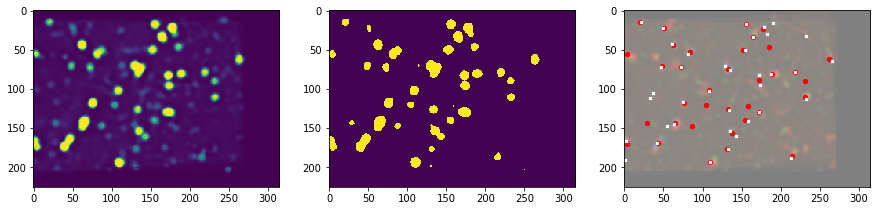

In [12]:
silce = 10

x = collman[:,silce-2:silce+2].mean(axis=1)
y  = inference(net,x,False)

img = x.transpose((1,2,0))*2.
img = np.dstack( ( img, np.ones_like(x[0])*0.5 ) )


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(y[0,0])
axes[1].imshow(y[0,0]>0.3)
axes[2].imshow(img)

gt_pts = np.array([np.array(b[silce])[:,1],np.array(b[silce])[:,0]]).transpose(1,0)


coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.3)) if p.area>5])
plt.scatter(coords[:,1],coords[:,0],s=20, c='red', marker='o')
plt.scatter(gt_pts[:,0],gt_pts[:,1],s=7, c='white', marker='x')


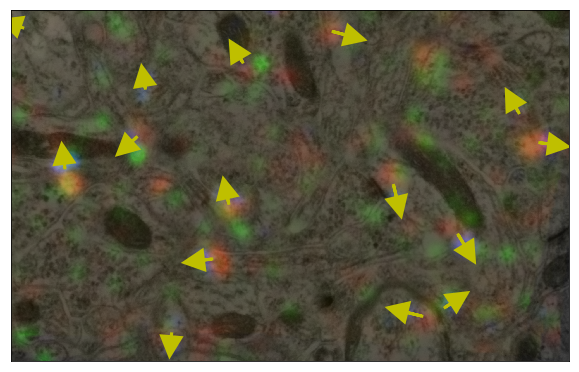

In [41]:
volume_slice = 22 #
em = np.load("../datasets/collman15/collman15v2_em.npz")['em'] #Saved only for 22th slice!!!


rx = slice(100,300)
ry = slice(100,300)

ver = 5

x = collman[:,volume_slice-2:volume_slice+2,rx,ry].mean(axis=1)

y  = inference(net,x,False)
coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.5)) if p.area>5])

img = x.transpose((1,2,0))*2.

fig,ax = plt.subplots(1, figsize=(10,10))
plt.setp(ax, xticks=[], yticks=[])


xem = em[rx.start*10:(rx.start+img.shape[0])*10,ry.start*10:(ry.start+img.shape[1])*10]

ax.imshow(xem,cmap='gray',extent=[0,img.shape[1],img.shape[0],0])
pic = img

#pic = (pic-np.min(pic)).astype(np.float32)/(np.max(pic)-np.min(pic)).astype(np.float32)
pic = (pic-np.min(pic,(0,1))).astype(np.float32)/(np.max(pic,(0,1))-np.min(pic,(0,1))).astype(np.float32)
pic = np.dstack( ( pic, np.ones_like(x[0])*0.65 ) )
ax.imshow(pic,interpolation='bilinear')
color=['r','g','b']


syn = dognet.extract_descriptor(x[0],coords[:,0],coords[:,1],10,get_gaussian=dognet.get_gaussian)    
psd = dognet.extract_descriptor(x[2],coords[:,0],coords[:,1],10,get_gaussian=dognet.get_gaussian)   
 
for s,p in zip(syn,psd):
    ax.arrow(s[0],s[1], p[0]-s[0], p[1]-s[1], head_width=7., head_length=7., fc='y', ec='y',lw=3)

### Export to csv descriptors

In [72]:
import pandas as pd
name = 'collman'
req_channels=['collman15v2_Synapsin647', 'collman15v2_VGluT1_647', 'collman15v2_PSD95_488']
dm=[]
for silce in range(2,25):
    x = collman[:,silce-2:silce+2].mean(axis=1)
    y  = inference(net,x)
    coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.5)) if p.area>1])
    
    for c in range(len(req_channels)):    
            desc = dognet.extract_descriptor(x[c],coords[:,0],coords[:,1],10,get_gaussian=dognet.get_gaussian)   
            dm+=[[silce,req_channels[c]]+d for d in desc]
            
dm = np.array(dm)            
d = {'fov': dm[:,0] , 'marker': dm[:,1],'x': dm[:,2] ,'y': dm[:,3] ,'A': dm[:,4] ,'L1': dm[:,5]
     ,'L2': dm[:,6] ,'sigmax2': dm[:,7],'sigmay2': dm[:,8],'sigmaxy': dm[:,9],'angle': dm[:,10],
     'x_dog': dm[:,11],'y_dog': dm[:,12]}
df = pd.DataFrame(data=d)
df.to_csv(name+".csv")

### Export results in order to compare with Probilistic synapse detection method

In [83]:
from skimage.transform import resize
import hdf5storage

results = []
for silce in range(27):
    x = collman[:,max(silce-2,0):min(silce+2,26)].mean(axis=1)
    y  = inference(net,x,False)
    results.append(resize(y[0,0]>0.3,(4518,6306)))
    
data = {u'resultVol':np.dstack(results).astype(np.double)}
hdf5storage.write(data, '.', 
                  'resultVol_1.mat', 
                  matlab_compatible=True)

### Benchmark code

In [52]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format


baselines = [dognet.baselines.Direct(3,3),
       dognet.baselines.FCN(3,4),
       dognet.baselines.FCN(3,3),      
       dognet.baselines.U_net(3,2),
       dognet.baselines.U_net(3,3)]

# deepdogs = [
#             dognet.SimpleIsotropic(3,15,3),
#        dognet.SimpleAnisotropic(3,15,3),
#        dognet.DeepAnisotropic(3,15,3,2),
#        dognet.DeepIsotropic(3,15,3,2)]
deepdogs = [
            dognet.SimpleIsotropic(3,15,2),
       dognet.SimpleAnisotropic(3,15,2),
       dognet.DeepAnisotropic(3,15,3,2,learn_amplitude=False),
       dognet.DeepIsotropic(3,15,3,2,learn_amplitude=False), 
            ]
def run_benchmark(networks,name,gen,nrun=0):
    result = []
    for n in networks:
        net,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=5,lr=0.001,loss='softdice',verbose=False)
        result.append([net.__class__,dognet.get_n_params(net)]+list(estimate_quality(collman,net,b,range(2,25),th=0.4)))
    df = pd.DataFrame(result)
    df.columns = ['name','#','f1','precision','recall','auc']
    df.to_csv('collman_results_{}_{}.csv'.format(name,nrun))
 
for nrun in range(3):
    run_benchmark(baselines+deepdogs,"all",dognet.create_generator(train_images[:2],train_labels[:2]),nrun)

In [53]:
csvs = [pd.read_csv('collman_results_all_{}.csv'.format(i)) for i in range(3)]
df_concat = pd.concat(csvs)
df_concat.groupby(level=0).mean()
#df_concat.groupby(level=0).std()

,Unnamed: 0,#,f1,precision,recall,auc
0,0,28,0.74,0.71,0.79,0.91
1,1,46,0.75,0.74,0.77,0.89
2,2,130,0.65,0.79,0.56,0.89
3,3,76,0.73,0.75,0.72,0.91


In [120]:
#Unsupervised Sihmal
import h5py
from skimage.transform import downscale_local_mean
path = '/media/hpc-4_Raid/vkulikov/hindus/probabilistic-synapse-detection/runme/collman_runme/resultsxxxx/resultVol_6.mat'
arrays = {}
f = h5py.File(path)
for k, v in f.items():
    arrays[k] = np.array(v)
rrr = downscale_local_mean(arrays['resultVol'].transpose(0,2,1),(1,20,20))
auc_score = []
for i in range(rrr.shape[0]):
    y_gt = make_labels(collman[:,0],np.array(b[i])[:,0],np.array(b[i])[:,1])
    fpr, tpr, thresholds = roc_curve( y_gt.flatten(),rrr[i,:,:-1].flatten())
    auc_score.append(auc(fpr, tpr))
print(np.array(auc_score).mean())

0.7449699325230736


(0.28812893404884493, 0.2580363623934701, 0.4356344518129074, 0.7107780970633405)


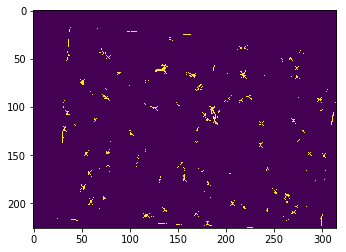

(0.14656385281385284, 0.10403091060985797, 0.3767712550607287, 0.631656747372186)


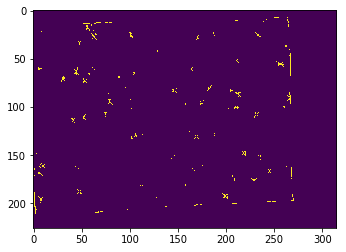

In [49]:
from skimage.filters import median, threshold_otsu, gaussian
from skimage.morphology import white_tophat,disk,black_tophat
import numpy as np

def cellprofiler_pipeline_single(img,sz=8,th=None):
    #1. estimate bg
    img = (img-img.min())/(img.max()-img.min())*255.
    bg = median(img.astype(np.uint8))#.astype(np.uint8),selem=np.ones((100,100))).astype(np.float32)
    #2. find the difference we are intrested in only higher values
    diff = img-bg
    diff[diff<0]=0.
    
    if th is None:
        th = threshold_otsu(diff.astype(np.uint8),255)
    #3. apply tophat    
    tophat = white_tophat(diff,selem=disk(sz))
    return tophat

def cellprofiler_pipeline(pre,post,sz=8,th=None):
    pre_process = np.zeros_like(pre[0])
    post_process = np.zeros_like(pre[0])
    for p in pre:
        pre_process+=cellprofiler_pipeline_single(p,sz,th)
    for p in post:
        post_process+=cellprofiler_pipeline_single(p,sz,th)
        
    pre_process/=len(pre)
    post_process/=len(post)
    return pre_process+post_process

auc_score = []
f1 =[]
rec =[]
prec=[]
for i in [3,4,5,6]:
    th=0.1
    auc_score = []
    r =cellprofiler_pipeline(collman[0:1,i],collman[1:2,i],20,None)
    r = (r-r.min())/(r.max()-r.min())
    plt.imshow(r>th)
    
    y_gt = make_labels(collman[:,0],np.array(b[i])[:,0],np.array(b[i])[:,1])
    fpr, tpr, thresholds = roc_curve( y_gt.flatten(),r.flatten())
    auc_score.append(auc(fpr, tpr))
    gt_pts = np.array([np.array(b[i])[:,1],np.array(b[i])[:,0]]).transpose(1,0)
    coords = np.array([ list(p.centroid) for p in regionprops(label(r>th)) if p.area>5])
    pts = np.array([coords[:,1],coords[:,0]]).transpose(1,0)

    precision,recall,f1_score,_ = dognet.get_metric(gt_pts,pts,s=10.)
    f1 +=[f1_score]
    rec +=[recall]
    prec+=[precision]
print(np.array(f1).mean(),np.array(prec).mean(),np.array(rec).mean(),np.array(auc_score).mean())

In [7]:
collman.max()

1.0